In [236]:
# things we want to capture:
# tangible equity/tangible asset -> we need tangible equity and tangible asset 
# - supposed to show the banks we're interested in don't have a very high EQUITY PERCENT relative to their ASSETS
# leverage ratio, apparently this is diff than tang asset percent
# Also use total debt / total assets == leverage
# leverage ratio = tier 1 capital / total consolidated assets
# tier 1 capital = shareholders equity + retained earnings

# gonna use long term debt / short term debt ratio


list_files = os.listdir("./assetsheets")
num_files = len(list_files)
arr = []
for file in list_files:
    file_path = "./assetsheets/" + file
    total_str = ""
    if (os.path.isfile(file_path)):
        with open(file_path,encoding='utf-8') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter='\n')
            for row in csv_reader:
                x = "".join(row)
                total_str += x
    arr.append(total_str)

    
svb_coords = []
sigbank_coords =[]
dict_data = {}
for data,bank in zip(arr,list_files):
#     print(data,bank)
    try:
#         print(bank)
        equity_tang_asset = data.split("Total Shareholders\' Equity / Total Assets")[1].split("Return On Average Total Equity")[0].replace(",","")
        split_eq = equity_tang_asset.split("%")
        last_eq = split_eq[0]
        total_asset_debt = data.split("X[:,1]")[1].split("Return On Average")[0].replace(",","")
        split_debt = total_asset_debt.split('%')
        last_tad = split_debt[0]
#         print(last_eq,last_tad)
        dict_data[bank] = [last_eq,last_tad]
#         print(last_eq,last_tad)
        if bank == '"SVB Financial Group**(Failed - Shutdown on Mar 10 2023)**".csv':
            svb_coords = [float(last_eq),float(last_tad)]
        elif bank == '"Signature Bank **(Failed - Shutdown on Mar 12 2023)**".csv':
            sigbank_coords = [float(last_eq),float(last_tad)]
        
            
        
    except:
        # cant find total equity / total assets
        pass
# print(dict_data)

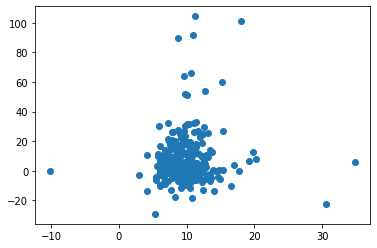

In [237]:
x = []
y = []

for value in dict_data.values():
    x.append(float(value[0]))
    y.append(float(value[1]))
plt.scatter(x,y)

# Below is what we're going to be sorting on gmm.. yikes


In [238]:
df = pd.DataFrame(
    {'eta': x,
     'tdta': y,
    })

In [239]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import os
import csv

In [240]:
def GMM(dat, k):
    
    #Comments will reference slides 26-31 from Feb 9
    
    """Define the variables we will use in the Algorithm"""
    #This represents Σ_m (covariance matrix of each component) (slide 26)
    covars=np.zeros((k,2,2))
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,2))
    
    #This represents W_m (weights/likelihood of each component) (slide 26 bottom)
    p_class=np.zeros(k)
    
    #This represents P(x_i | cluster = m), or Φ(x_i | μ_m, Σ_m) (slide 27)
    #During the Expectation step, we will use this to derive p̂_mi (or p_class_given_data) as shown on slide 27
    #p_class_given_data will be the same shape
    
    # Use p_data_given_class to derive p_mi for expectation step. 
    p_data_given_class=np.zeros((len(dat),k))
    
    p_class_given_data=np.zeros((len(dat),k))
    

    
    """Initialize means, covs, p_classes"""
    #initializations of starting points (used to set the initial means below)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    # we get k indices of random data points. 
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        # changes rows into columns and columns into rows
        # this rets a 2x2 covariance, we set it for each dimension
        covars[dim,:,:]=np.cov(np.transpose(dat))
        

        #Set initial means to initial chosen data points (slide 26)
        # we just set to some data points we have.
        
        # Remember we picked dim number of random indices. Now we're just getting that random number and setting the means to it
        # the means[dim,:] means setting latitude and longitude
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
    
    """Now Iterate"""
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    #Note - 50 steps is fine, no requirement to check for convergence on this HW
    for step in range(50):
        # we run it 50 times to get to a convergence of our means, covars, etc. for each cluster
        """Expectation Step (Slide 27)"""
        for i in range(len(dat)):
            for dim in range(k):
                x = dat.iloc[i,0]
                y = dat.iloc[i,1]
    
                # gives us unnormalized probability of being in each cluster
                pmi = stats.multivariate_normal.pdf(x=(x,y), mean=means[dim], cov=covars[dim,:,:], allow_singular=True)
                p_data_given_class[i][dim] = pmi*p_class[dim]

        # normalize them now
        for i in range(len(dat)):
            summ = sum(p_data_given_class[i])
            for dim in range(k):
                p_class_given_data[i][dim] = p_data_given_class[i][dim]/summ

        
        """Maximization Step (Slide 29-30)"""
        
        new_weights = p_class=np.zeros(k)
        new_means = np.zeros((k,2))
        new_covars = np.zeros((k,2,2))
        for dim in range(k):
            nm = 0
            x_mean_sum = 0
            y_mean_sum = 0
            x_covar = 0
            y_covar = 0
            covar_new = np.zeros((2,2))
            for i in range(len(dat)):
                nm += p_class_given_data[i][dim]
                x_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,0])
                y_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,1])
                
            # change weights
            new_weights[dim] = nm/len(dat)
            # change means using nm and mean_sum's calc'd above
            new_means[dim] = [(x_mean_sum/nm),(y_mean_sum/nm)]
            total = np.zeros((2, 2))
            for j in range(len(dat)):
                total += p_class_given_data[j, dim] * np.outer(list(dat.iloc[j,:]) - means[dim], list(dat.iloc[j,:]) - means[dim])
#             print(nm)
            covars[dim] = total / nm
        
            
        # set all of our new vars
        means = new_means
        p_class = new_weights
            

#     """Once we're done with our for loop, we compute the mean dist (This formula is given in the HW below in Part B)"""
#     sum_iter = 0
#     for i in range(len(dat)):
#         for m in range(k):
#             pmi = p_class_given_data[i][m]
#             # need to weight points that are closer to mean higher>
#             dist_x = (dat.iloc[i,0]-means[dim][0])**2
#             dist_y = (dat.iloc[i,1]-means[dim][1])**2
# #             sum_iter += (comb*(dist_y))
# #             sum_iter += (comb*(dist_y))
#     n = len(dat)
#     mean_dist = (sum_iter/n)**1/2
    

    #Return all the needed variables
    return p_class_given_data, means, covars, p_class



In [241]:
p_class_given_data_lst = []
means_lst = []
covars_lst = []
p_class_lst = []
mean_dist_lst = []


for i in range(1,9):
    print("Testing for K: " + str(i))
    p_class_given_data, means, covars, p_class = GMM(df, i)
    print(means)
    p_class_given_data_lst.append(p_class_given_data)
    means_lst.append(means)
    covars_lst.append(covars)
    p_class_lst.append(p_class)


Testing for K: 1
[[9.78439597 7.33848993]]
Testing for K: 2
[[ 9.42157904  4.927842  ]
 [13.30017007 30.69818668]]
Testing for K: 3
[[10.15141106 30.63641914]
 [14.54811374  0.1535884 ]
 [ 9.39077305  3.94806149]]
Testing for K: 4
[[10.21221306 41.75833794]
 [10.34019578  9.97676284]
 [14.08319232 -0.41635939]
 [ 8.78006118  1.40426166]]
Testing for K: 5
[[ 1.01610015e+01  2.51425289e-01]
 [ 1.02897293e+01  4.46013413e+01]
 [ 1.42981212e+01 -4.09023577e-02]
 [ 8.15185533e+00  3.57777665e+00]
 [ 9.95757266e+00  1.51405259e+01]]
Testing for K: 6
[[ 8.70210873  1.61221715]
 [ 8.57678758  6.23931749]
 [10.15572438  0.67333094]
 [10.39249473 46.9575265 ]
 [15.14702195  1.35290644]
 [10.350388   19.02948392]]
Testing for K: 7
[[11.54173262 69.35042885]
 [15.00624323  1.3060189 ]
 [ 9.04245872 16.06136938]
 [ 9.84055733  4.54556018]
 [ 8.92157856  1.45667602]
 [11.0184824  -0.35866792]
 [ 8.32545832  2.07371915]]
Testing for K: 8
[[11.67816726 -1.75369312]
 [ 8.29920973 12.45649595]
 [ 9.5496

In [245]:
k_num = -1

In [246]:

dict_pts = {}
for idx,data in enumerate(p_class_given_data_lst[k_num]):
    lst = list(data)
    max_value = max(lst)
    index = lst.index(max_value)
    our_point = df.iloc[idx,:]
    our_point_lst = list(our_point)
    if index not in dict_pts:
        dict_pts[index] = [our_point_lst]
    else:
        dict_pts[index].append(our_point_lst)

[7.56, -0.1]
[7.24, -6.78]


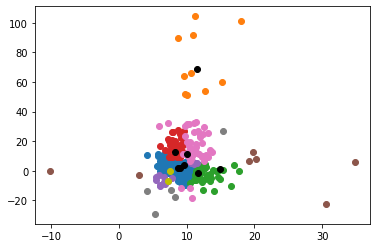

In [247]:

for key, value in dict_pts.items():
    x = [i[0] for i in dict_pts[key]]
    y = [i[1] for i in dict_pts[key]]
    plt.scatter(x,y)
plt.scatter([i[0] for i in means_lst[k_num]], [i[1] for i in means_lst[k_num]], color="black")
print(svb_coords)
print(sigbank_coords)
plt.scatter(svb_coords[0], svb_coords[1], color="y")
plt.scatter(sigbank_coords[0], sigbank_coords[1], color="y")